In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load the dataset

In [2]:
import pandas as pd
import os

dataset_dir = '/content/gdrive/MyDrive/Essentials in Text and Speech Processing'

x_train = pd.read_csv(os.path.join(dataset_dir, 'x_train.csv'))
x_test = pd.read_csv(os.path.join(dataset_dir, 'x_test.csv'))
y_train = pd.read_csv(os.path.join(dataset_dir, 'y_train.csv'))
y_test = pd.read_csv(os.path.join(dataset_dir, 'y_test.csv'))


## Preprocess one more time lol

In [3]:
# Check for missing values in x_train
missing_values_train = x_train.isnull().sum()
missing_values_test = x_test.isnull().sum()

print(f"Missing values in x_train:\n{missing_values_train[missing_values_train > 0]}")
print(f"Missing values in x_test:\n{missing_values_test[missing_values_test > 0]}")

Missing values in x_train:
requirements    3
dtype: int64
Missing values in x_test:
description     1
requirements    3
dtype: int64


In [4]:
x_train['requirements'] = x_train['requirements'].fillna('')
x_test['requirements'] = x_test['requirements'].fillna('')
x_test['description'] = x_test['description'].fillna('')

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer(max_features=5000)

x_train_tfidf = vectorizer.fit_transform(x_train['title'] + " " + x_train['company_profile'] + " " + x_train['description'] + " " + x_train['requirements'])

x_test_tfidf = vectorizer.transform(x_test['title'] + " " + x_test['company_profile'] + " " + x_test['description'] + " " + x_test['requirements'])

x_train = pd.DataFrame(x_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
x_test = pd.DataFrame(x_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

print(x_train.shape, x_test.shape)


(14304, 5000) (3576, 5000)


In [6]:
# Flatten y_train and y_test by converting them to NumPy arrays and then applying ravel
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

## Oversampling the minority class




In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

#oversampling
smote = SMOTE(sampling_strategy='minority', random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)


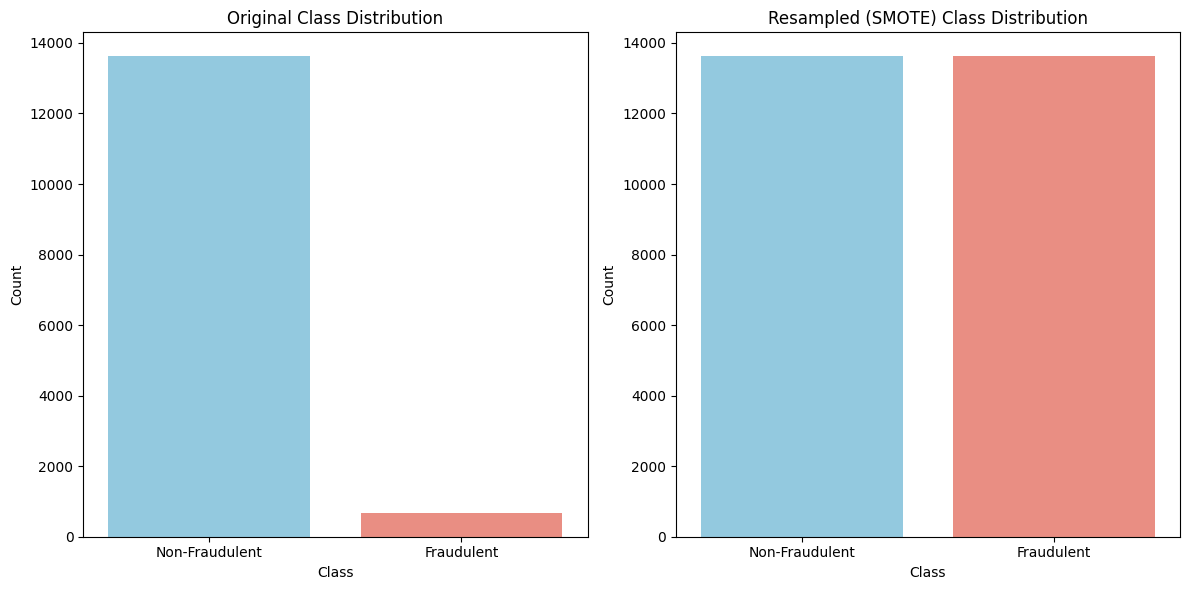

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Plot original and resampled class distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original data distribution
sns.countplot(x=y_train, ax=ax[0], hue=y_train, palette=['skyblue', 'salmon'], legend=False)
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# Set the number of ticks before using set_xticklabels
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Non-Fraudulent', 'Fraudulent'])

# Resampled (SMOTE) data distribution
sns.countplot(x=y_train_res, ax=ax[1], hue=y_train_res, palette=['skyblue', 'salmon'], legend=False)
ax[1].set_title('Resampled (SMOTE) Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

# Set the number of ticks before using set_xticklabels
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Non-Fraudulent', 'Fraudulent'])

plt.tight_layout()
plt.show()

## Train the model (logistic)



In [9]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression with appropriate settings
logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logistic_model.fit(x_train_res, y_train_res)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

## Evaluate the model

In [10]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

y_pred = logistic_model.predict(x_test)

# Get accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)



##Show the results

In [11]:
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 97.29%
Precision: 0.9771
Recall: 0.9729
F1 Score: 0.9744
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3395
           1       0.68      0.87      0.76       181

    accuracy                           0.97      3576
   macro avg       0.84      0.92      0.87      3576
weighted avg       0.98      0.97      0.97      3576

Confusion Matrix:
 [[3322   73]
 [  24  157]]


In [12]:
import numpy as np
feature_names = vectorizer.get_feature_names_out()
coefficients = logistic_model.coef_[0]

# Combine and sort features by absolute coefficient size
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
top_features = feature_importance.sort_values(by='Abs_Coefficient', ascending=False).head(20)
print("top features", top_features)


top features          Feature  Coefficient  Abs_Coefficient
4666     unknown     8.295473         8.295473
3110         our    -5.931964         5.931964
370     aptitude     5.907340         5.907340
116       accion     5.232570         5.232570
1563       entry     4.959839         4.959839
2853       money     4.644581         4.644581
825        clerk     4.305005         4.305005
555        below     4.185920         4.185920
691         call     4.113600         4.113600
418    assistant     4.082336         4.082336
1423        earn     3.999931         3.999931
2438          it    -3.963047         3.963047
4669   unmatched     3.957882         3.957882
254         aker     3.916634         3.916634
4314      subsea     3.911891         3.911891
2586  leveraging     3.803880         3.803880
2138         his     3.749984         3.749984
1953         gas     3.706076         3.706076
3265       phone     3.645573         3.645573
829       client    -3.523645         3.523645
